In [1]:
# 1) Imports
import os
import re
import torch
import numpy as np
import matplotlib.pyplot as plt
import pulp
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig # Added BitsAndBytesConfig
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, TaskType
# import bitsandbytes as bnb # Not explicitly used if BitsAndBytesConfig is from transformers

# 2) Convex Oracle: PuLP optimization for TCL problem
def generate_optimal_schedule(prices, ambient_temperatures, P_AC, T0, Tmin, Tmax, alpha, G, peak):
    N = len(prices) - 1
    prob = pulp.LpProblem("TCL", pulp.LpMinimize)
    x1 = [pulp.LpVariable(f"x1_{n}", 0, 1) for n in range(N+1)]
    x2 = [pulp.LpVariable(f"x2_{n}", 0, 1) for n in range(N+1)]
    T1 = [pulp.LpVariable(f"T1_{n}", Tmin[0], Tmax[0]) for n in range(N+1)]
    T2 = [pulp.LpVariable(f"T2_{n}", Tmin[1], Tmax[1]) for n in range(N+1)]
    prob += pulp.lpSum(prices[n] * (P_AC[0]*x1[n] + P_AC[1]*x2[n]) for n in range(N+1))
    prob += T1[0] == T0[0]
    prob += T2[0] == T0[1]
    for n in range(N):
        prob += T1[n+1] == T1[n] + alpha[0]*(ambient_temperatures[n] - T1[n]) + G[0]*P_AC[0]*x1[n]
        prob += T2[n+1] == T2[n] + alpha[1]*(ambient_temperatures[n] - T2[n]) + G[1]*P_AC[1]*x2[n]
    for n in range(N+1):
        prob += P_AC[0]*x1[n] + P_AC[1]*x2[n] <= peak
    prob.solve(pulp.PULP_CBC_CMD(msg=False))
    return {
        'x1': np.array([pulp.value(v) for v in x1]),
        'x2': np.array([pulp.value(v) for v in x2])
    }

# 3) Dataset for TCL problem
class TCLSupervisedDatasetStructured(Dataset):
    def __init__(self, n_samples, N):
        self.prompts = []
        self.targets = []
        self.N = N
        self.P_AC = [2.0, 2.5]
        self.H = len(self.P_AC)
        self.T0 = [25.0, 24.0]
        self.Tmin_range = [(20,23),(19,22)]
        self.Tmax_range = [(26,29),(25,28)]
        self.alpha = [0.1,0.1]
        self.G     = [-0.3,-0.3]
        self.peak_range = (3,6)

        for _ in range(n_samples):
            prices = 0.05 + 0.15*np.random.rand(N+1)
            temps  = 28   +  7*np.random.rand(N+1)
            peak   = np.random.uniform(*self.peak_range)
            Tmin   = [np.random.uniform(*r) for r in self.Tmin_range]
            Tmax   = [np.random.uniform(*r) for r in self.Tmax_range]

            opt = generate_optimal_schedule(prices, temps, self.P_AC, self.T0, Tmin, Tmax, self.alpha, self.G, peak)
            prompt = self._build_prompt(prices, temps, peak, Tmin, Tmax)
            target = self._schedules_to_text(opt['x1'], opt['x2'])

            self.prompts.append(prompt)
            self.targets.append(target)

    def _build_prompt(self, prices, temps, peak, Tmin, Tmax):
        s = "[Prices]\n" + "\n".join(f"Slot {i}: {p:.3f} $/kWh" for i,p in enumerate(prices))
        s += "\n\n[Ambient Temperatures]\n" + "\n".join(f"Slot {i}: {t:.1f}°C" for i,t in enumerate(temps))
        s += "\n\n[AC Units]\n"
        for i,(p,t0,tmin,tmax) in enumerate(zip(self.P_AC,self.T0,Tmin,Tmax),1):
            s += (f"AC Unit {i}:\n"
                  f"  Power: {p} kW\n"
                  f"  Initial Temp: {t0}°C\n"
                  f"  Min Temp: {tmin:.1f}°C\n"
                  f"  Max Temp: {tmax:.1f}°C\n")
        s += f"\n[Peak Limit]\n{peak:.1f} kW\n"
        s += "[Thermal Parameters]\n"
        s += f"Alpha: {self.alpha}\nG: {self.G}\n"
        s += "[Objective]\nMinimize electricity cost while maintaining comfort.\n"
        s += (f"\n[Output]\n"
              f"Provide only a {(self.N+1)}x{self.H} matrix. "
              "Each row has two numbers (0–1) separated by comma, rows by semicolons.")
        return s

    def _schedules_to_text(self, x1, x2):
        return ",".join(f"{v:.2f}" for v in x1) + ";" + ",".join(f"{v:.2f}" for v in x2)

    def __len__(self): return len(self.prompts)
    def __getitem__(self, idx): return self.prompts[idx], self.targets[idx]

# 4) PhiScheduler with LoRA
class PhiScheduler:
    def __init__(self, model_name="microsoft/Phi-3-mini-4k-instruct"):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
        self.tokenizer.pad_token = self.tokenizer.eos_token

        # Define BitsAndBytesConfig for 4-bit quantization
        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",  # Recommended for better precision
            bnb_4bit_compute_dtype=torch.bfloat16, # For faster computation if GPU supports (RTX A5500 does)
            bnb_4bit_use_double_quant=False, # Common setting
        )

        self.model = AutoModelForCausalLM.from_pretrained(
            model_name,
            device_map="auto",
            quantization_config=bnb_config, # Pass the explicit config
            trust_remote_code=True,
            attn_implementation="eager"  # Force eager attention to potentially avoid cache issues
        )
        self.model = prepare_model_for_kbit_training(self.model)
        cfg = LoraConfig(r=8, lora_alpha=16,
                         target_modules=["q_proj","k_proj","v_proj","o_proj"],
                         lora_dropout=0.05, bias="none", task_type=TaskType.CAUSAL_LM)
        self.model = get_peft_model(self.model, cfg)
        self.model.print_trainable_parameters()
        self.model.eval()
        self.N = None # To be set by the main script based on dataset

    def fine_tune(self, ds, epochs=1, batch_size=1, lr=2e-4):
        self.model.train()
        loader = DataLoader(ds, batch_size=batch_size, shuffle=True)
        opt = AdamW(self.model.parameters(), lr=lr)
        for ep in range(1,epochs+1):
            tot=0
            for ps,ts in loader:
                texts=[p + "\n\n" + t + self.tokenizer.eos_token for p, t in zip(ps, ts)]
                enc=self.tokenizer(texts,return_tensors="pt",padding=True,truncation=True, max_length=512).to(self.model.device)
                outputs=self.model(**enc,labels=enc["input_ids"])
                loss=outputs.loss
                opt.zero_grad(); loss.backward(); opt.step()
                tot+=loss.item()*len(ps)
            print(f"Epoch {ep}/{epochs} AvgLoss={tot/len(ds):.6f}")
        self.model.eval()
        return self

    def generate_schedule(self, prompt):
        self.model.eval()
        inputs=self.tokenizer(prompt,return_tensors="pt",padding=True,truncation=True, max_length=512).to(self.model.device)
        with torch.no_grad():
            outputs = self.model.generate(
                **inputs,
                max_new_tokens=200,
                do_sample=False,
                pad_token_id=self.tokenizer.eos_token_id, # Comma was fixed here
                use_cache=True # Explicitly enable cache for generation
            )
        
        generated_ids = outputs[0, inputs['input_ids'].shape[1]:]
        full_decoded_text = self.tokenizer.decode(generated_ids, skip_special_tokens=True)
        
        numerical_part = re.sub(r'[^0-9.,;]','', full_decoded_text)
        
        if len(numerical_part) > 20: # Arbitrary threshold
            return numerical_part
        else:
            print(f"Warning: Generated output has minimal numerical content. Output: '{full_decoded_text}'")
            return full_decoded_text

# 5) parse helper
def parse_phi_output(output_str, N_slots):
    try:
        match = re.search(r'([\d.,]+);([\d.,]+)', output_str)
        if not match:
            print(f"Parsing error: Could not find 'data;data' pattern in output: {output_str}")
            return np.zeros(N_slots), np.zeros(N_slots)

        a_str, b_str = match.group(1), match.group(2)
        x1 = np.array([float(v) for v in a_str.split(",")[:N_slots]])
        x2 = np.array([float(v) for v in b_str.split(",")[:N_slots]])
        
        if len(x1) < N_slots: x1 = np.pad(x1, (0, N_slots - len(x1)), 'constant')
        if len(x2) < N_slots: x2 = np.pad(x2, (0, N_slots - len(x2)), 'constant')
            
        return x1, x2
    except Exception as e:
        print(f"Parsing error: {e}. Output was: '{output_str}'")
        return np.zeros(N_slots), np.zeros(N_slots)

# 6) Test & Plot with comparison
def test_and_plot(scheduler, tests=3, N_param=25):
    P_AC=np.array([2.0,2.5]); T0=np.array([25.0,24.0])
    alpha=np.array([0.1,0.1]); G=np.array([-0.3,-0.3])
    ds0 = TCLSupervisedDatasetStructured(n_samples=0, N=N_param) 
    num_slots = N_param + 1

    for ti in range(1,tests+1):
        prices=0.05+0.15*np.random.rand(num_slots)
        temps =28  + 7*np.random.rand(num_slots)
        peak  =np.random.uniform(3,6)
        Tmin  =[np.random.uniform(*r) for r in ds0.Tmin_range]
        Tmax  =[np.random.uniform(*r) for r in ds0.Tmax_range]

        prompt=ds0._build_prompt(prices,temps,peak,Tmin,Tmax)
        generated_text_output = scheduler.generate_schedule(prompt)
        x1p,x2p = parse_phi_output(generated_text_output, num_slots)

        opt = generate_optimal_schedule(prices,temps,P_AC,T0,Tmin,Tmax,alpha,G,peak)
        x1o,x2o = opt['x1'],opt['x2']

        cost_p = np.sum(prices*(x1p*P_AC[0] + x2p*P_AC[1]))
        cost_o = np.sum(prices*(x1o*P_AC[0] + x2o*P_AC[1]))
        
        if len(x1p) == len(x1o) and len(x2p) == len(x2o):
            mse = np.mean((np.hstack([x1p,x2p]) - np.hstack([x1o,x2o]))**2)
        else:
            mse = float('nan')
            print(f"Warning: Length mismatch for MSE calc. x1p:{len(x1p)}, x1o:{len(x1o)}, x2p:{len(x2p)}, x2o:{len(x2o)}")

        print(f"Test {ti}: PhiCost=${cost_p:.2f}, OptCost=${cost_o:.2f}, Gap=${cost_p-cost_o:.2f}, MSE={mse:.4f}")
        
        plt.figure(figsize=(12, 6))
        plt.subplot(2,1,1)
        plt.plot(x1o, label='Optimal x1', linestyle='--')
        plt.plot(x2o, label='Optimal x2', linestyle='--')
        plt.plot(x1p, label='Predicted x1')
        plt.plot(x2p, label='Predicted x2')
        plt.title(f'Test {ti} - Predicted vs Optimal Schedules')
        plt.ylabel('Activation (0-1)')
        plt.legend()
        
        plt.subplot(2,1,2)
        total_power_opt = x1o*P_AC[0] + x2o*P_AC[1]
        total_power_pred = x1p*P_AC[0] + x2p*P_AC[1]
        plt.plot(total_power_opt, label='Optimal Total Power', linestyle='--')
        plt.plot(total_power_pred, label='Predicted Total Power')
        plt.axhline(peak, color='r', linestyle=':', label=f'Peak Limit ({peak:.1f}kW)')
        plt.title(f'Test {ti} - Total Power Consumption')
        plt.xlabel('Time Slot')
        plt.ylabel('Power (kW)')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

# 7) Main
if __name__ == "__main__":
    N_intervals = 25
    
    print("--- Generating Dataset ---")
    ds = TCLSupervisedDatasetStructured(n_samples=100, N=N_intervals) # Using 100 samples for quicker runs
    
    print("--- Initializing Scheduler ---")
    scheduler = PhiScheduler()
    scheduler.N = N_intervals # Pass N_intervals to scheduler if it needs it (e.g. for prompt building if done inside)
    
    print("--- Starting Fine-tuning ---")
    scheduler.fine_tune(ds, epochs=2, batch_size=1, lr=2e-4) # User requested 5 epochs
    
    save_dir="phi3_lora_finetuned_tcl_custom"
    os.makedirs(save_dir, exist_ok=True)
    
    print(f"--- Saving model and tokenizer to ./{save_dir} ---")
    scheduler.model.save_pretrained(save_dir)
    scheduler.tokenizer.save_pretrained(save_dir)
    print(f"Saved to ./{save_dir}")
    
    print("--- Running Tests & Plots ---")
    test_and_plot(scheduler, tests=3, N_param=N_intervals)

    # Optional: Interactive mode (can be commented out)
    # print("=== Interactive Test Mode ===")
    # print("Type 'exit' or 'quit' to stop.")
    # ds_interactive = TCLSupervisedDatasetStructured(n_samples=0, N=N_intervals)
    # while True:
    #     user_input_raw = input("Build a new test case? (y/n) or type 'exit': ")
    #     if user_input_raw.lower() in("exit","quit"): break
    #     if user_input_raw.lower() == 'y':
    #         prices_interactive = 0.05 + 0.15 * np.random.rand(N_intervals + 1)
    #         temps_interactive = 28 + 7 * np.random.rand(N_intervals + 1)
    #         peak_interactive = np.random.uniform(*ds_interactive.peak_range)
    #         Tmin_interactive = [np.random.uniform(*r) for r in ds_interactive.Tmin_range]
    #         Tmax_interactive = [np.random.uniform(*r) for r in ds_interactive.Tmax_range]
    #         interactive_prompt = ds_interactive._build_prompt(prices_interactive, temps_interactive, peak_interactive, Tmin_interactive, Tmax_interactive)
    #         print("\n--- Generated Test Prompt ---")
    #         print(interactive_prompt)
    #         print("\n--- Model Generation ---")
    #         generated_output = scheduler.generate_schedule(interactive_prompt)
    #         print("Raw Output:", generated_output)
    #         x1_interactive, x2_interactive = parse_phi_output(generated_output, N_intervals + 1)
    #         print("Parsed x1:", x1_interactive)
    #         print("Parsed x2:", x2_interactive)
    #         print("---------------------------\n")

--- Generating Dataset ---
--- Initializing Scheduler ---


`flash-attention` package not found, consider installing for better performance: No module named 'flash_attn'.
Current `flash-attention` does not support `window_size`. Either upgrade or use `attn_implementation='eager'`.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/home/sjim/anaconda3/envs/Jim1/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
You are not running the flash-attention implementation, expect numerical differences.


trainable params: 1,572,864 || all params: 3,822,652,416 || trainable%: 0.0411
--- Starting Fine-tuning ---
Epoch 1/2 AvgLoss=0.329396


The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.


Epoch 2/2 AvgLoss=0.298796
--- Saving model and tokenizer to ./phi3_lora_finetuned_tcl_custom ---
Saved to ./phi3_lora_finetuned_tcl_custom
--- Running Tests & Plots ---


AttributeError: 'DynamicCache' object has no attribute 'get_max_length'

In [2]:
import os

current_directory = os.getcwd()
print(current_directory)

/home/sjim/Courses/Real Time ML/Project


In [ ]:
print(type(past_key_values))
print(dir(past_key_values)) # This will list all its attributes and methods

/bin/bash: /home/sjim/anaconda3/envs/Jim1/lib/libtinfo.so.6: no version information available (required by /bin/bash)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Using model: NousResearch/Llama-2-7b-chat-hf
Dataset Size: 100, Epochs: 5, Batch Size: 1, LR: 5e-05

--- Generating Dataset (100 samples) ---
Attempting to generate 100 valid dataset samples...
Attempt 30/300, Generated 29/100
Attempt 60/300, Generated 56/100
Attempt 90/300, Generated 86/100
Successfully generated 100 dataset samples.
Dataset generated in 0.52 seconds.

--- Loading LLM (NousResearch/Llama-2-7b-chat-hf) with LoRA ---
Initializing LLMScheduler with model: NousResearch/Llama-2-7b-chat-hf


tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

Loading model NousResearch/Llama-2-7b-chat-hf with quantization...


config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

Model loaded.
Model prepared for k-bit training.


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


trainable params: 39,976,960 || all params: 6,778,392,576 || trainable%: 0.5898
Model loaded in 162.04 seconds.

--- Fine-tuning (LoRA) for 5 Epochs ---
Starting fine-tuning with N=25, H=2, BS=1, LR=5e-05 for 5 epochs.


/home/sjim/anaconda3/envs/Jim1/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/sjim/anaconda3/envs/Jim1/lib/python3.12/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


  Epoch 1, Batch 1/100, Current Batch Loss: 1.002921
  Epoch 1, Batch 21/100, Current Batch Loss: 0.239960
  Epoch 1, Batch 41/100, Current Batch Loss: 0.200050
  Epoch 1, Batch 61/100, Current Batch Loss: 0.170671
  Epoch 1, Batch 81/100, Current Batch Loss: 0.171038
Fine-tuning Epoch 1/5 — Avg Loss: 0.262053
  Epoch 2, Batch 1/100, Current Batch Loss: 0.162067
  Epoch 2, Batch 21/100, Current Batch Loss: 0.158562
  Epoch 2, Batch 41/100, Current Batch Loss: 0.165796
  Epoch 2, Batch 61/100, Current Batch Loss: 0.178238
  Epoch 2, Batch 81/100, Current Batch Loss: 0.170997
Fine-tuning Epoch 2/5 — Avg Loss: 0.165404
  Epoch 3, Batch 1/100, Current Batch Loss: 0.164984
  Epoch 3, Batch 21/100, Current Batch Loss: 0.165353
  Epoch 3, Batch 41/100, Current Batch Loss: 0.163649
  Epoch 3, Batch 61/100, Current Batch Loss: 0.159259
  Epoch 3, Batch 81/100, Current Batch Loss: 0.171030
Fine-tuning Epoch 3/5 — Avg Loss: 0.161854
  Epoch 4, Batch 1/100, Current Batch Loss: 0.155741
  Epoch 4, 

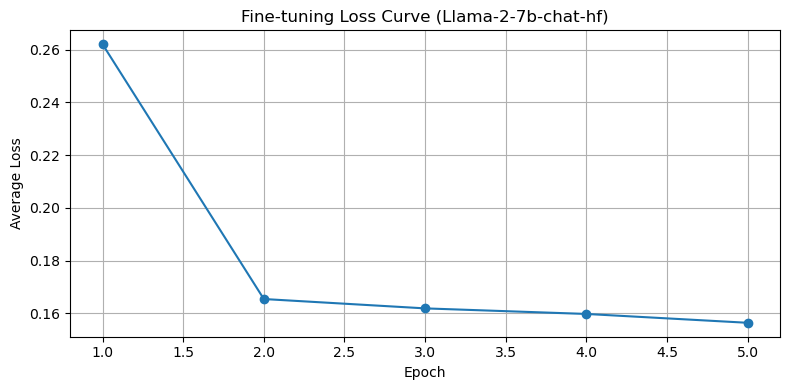

Fine-tuning completed in 875.00 seconds.

--- Testing Model on 3 Scenarios ---

--- Running 3 Test Scenarios ---

--- Test Scenario 1/3 ---


/home/sjim/anaconda3/envs/Jim1/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:629: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/sjim/anaconda3/envs/Jim1/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:634: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


Generated Output (Raw - first 300 chars):
---
0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;1.0,1.0;</s>
</Response>
<Explanation>
The activation schedule is a 25x2 matrix, where each row represents t
---
Parsed Schedule (Predicted):
----  ----
0.00  0.00
0.00  0.00
0.00  0.00
0.00  0.00
0.00  0.00
0.00  0.00
0.00  0.00
0.00  0.00
0.00  0.00
0.00  0.00
0.00  0.00
0.00  0.00
0.00  0.00
0.00  0.00
0.00  0.00
0.00  0.00
0.00  0.00
0.00  0.00
0.00  0.00
0.00  0.00
0.00  0.00
0.00  0.00
0.00  0.00
0.00  0.00
1.00  1.00
----  ----
Optimal Schedule:
-----  -----
-0.00  -0.00
-0.00  -0.00
-0.00  -0.00
-0.00  -0.00
-0.00  -0.00
-0.00  -0.00
-0.00  -0.00
 1.00   1.00
-0.00  -0.00
-0.00  -0.00
-0.00  -0.00
 0.00   0.00
-0.00  -0.00
-0.00  -0.00
-0.00  -0.00
 1.00   1.00
 0.00   0.00
-0.00  -0.00
 1.00   1.00
 0.00   1.00
-0.00  -0.00
-0.00  -0.00
-0.00 

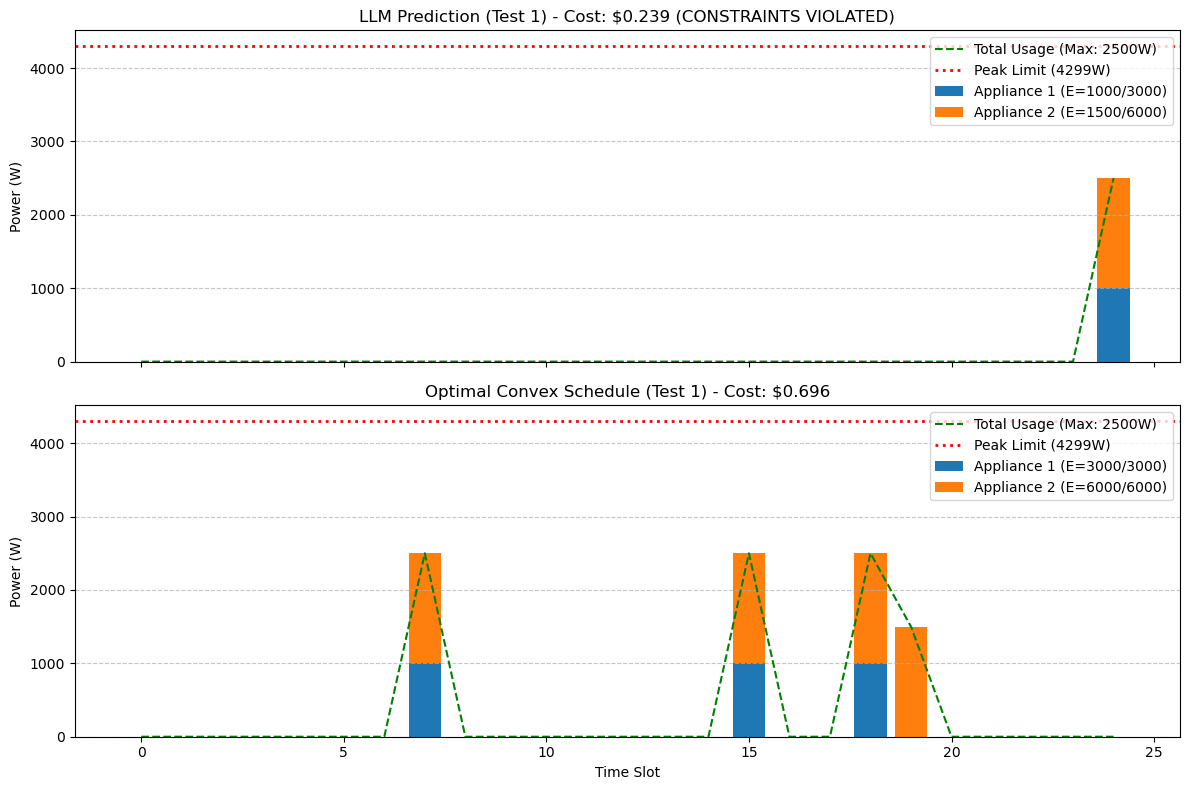


--- Test Scenario 2/3 ---
Generated Output (Raw - first 300 chars):
---
0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;</s>
</Response>
<Explanation>
The activation schedule is a 25x2 matrix, where each row represents t
---
Parsed Schedule (Predicted):
----  ----
0.00  0.00
0.00  0.00
0.00  0.00
0.00  0.00
0.00  0.00
0.00  0.00
0.00  0.00
0.00  0.00
0.00  0.00
0.00  0.00
0.00  0.00
0.00  0.00
0.00  0.00
0.00  0.00
0.00  0.00
0.00  0.00
0.00  0.00
0.00  0.00
0.00  0.00
0.00  0.00
0.00  0.00
0.00  0.00
0.00  0.00
0.00  0.00
0.00  0.00
----  ----
Optimal Schedule:
-----  -----
 0.78   1.00
-0.00  -0.00
-0.00  -0.00
-0.00  -0.00
-0.00  -0.00
-0.00  -0.00
-0.00  -0.00
-0.00  -0.00
-0.00  -0.00
-0.00  -0.00
-0.00  -0.00
-0.00  -0.00
 0.66   1.00
-0.00  -0.00
-0.00  -0.00
-0.00  -0.00
-0.00  -0.00
-0.00  -0.00
-0.00  -0.00
 0.78   1.00
-0.00

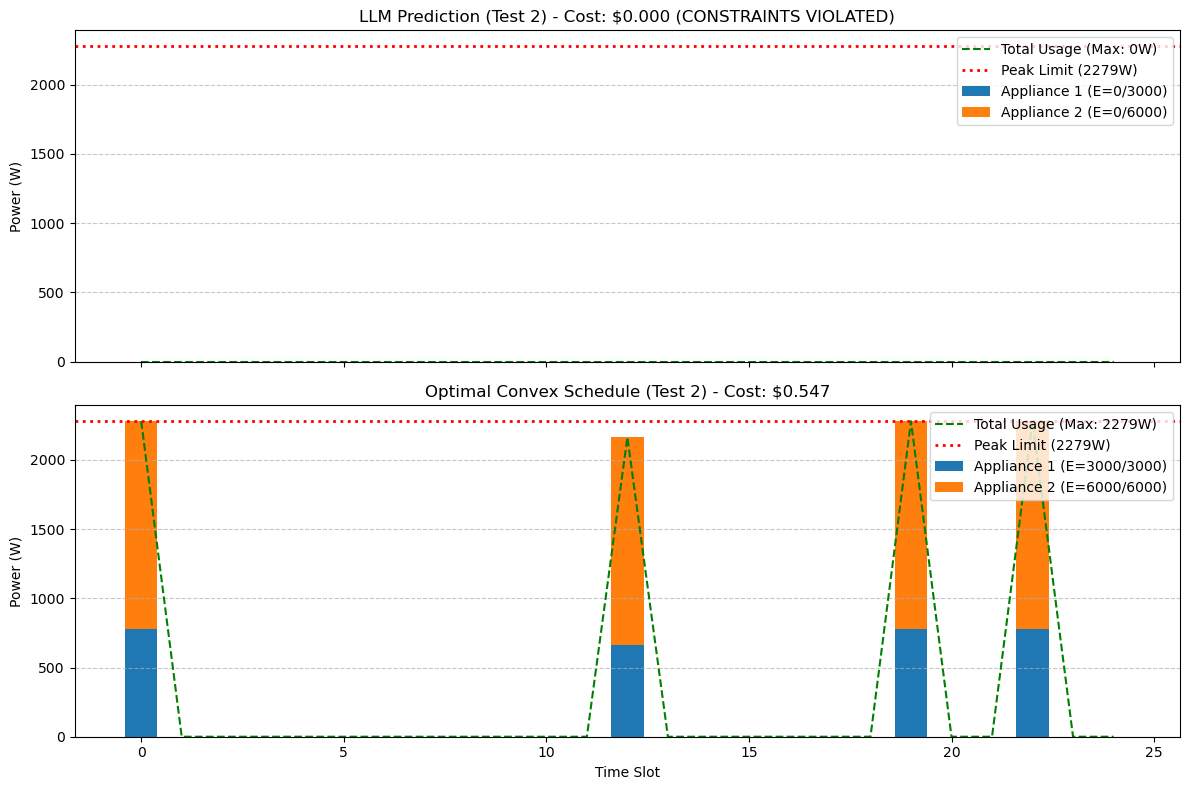


--- Test Scenario 3/3 ---
Generated Output (Raw - first 300 chars):
---
0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;</s>
0.0,0.0;0.0,0.0;</s>
0.0,0.0;</s>
0.0,0.0;</s>
0.0,0.0;</s>
0.0,0.0;</s>
0.0,0.0;</s>
0.0,0.0;<
---
Parsed Schedule (Predicted):
----  ----
0.00  0.00
0.00  0.00
0.00  0.00
0.00  0.00
0.00  0.00
0.00  0.00
0.00  0.00
0.00  0.00
0.00  0.00
0.00  0.00
0.00  0.00
0.00  0.00
0.00  0.00
0.00  0.00
0.00  0.00
0.00  0.00
0.00  0.00
0.00  0.00
0.00  0.00
0.00  0.00
0.00  0.00
0.00  0.00
0.00  0.00
0.00  0.00
0.00  0.00
----  ----
Optimal Schedule:
-----  -----
-0.00  -0.00
-0.00  -0.00
 1.00   1.00
-0.00  -0.00
-0.00  -0.00
-0.00  -0.00
-0.00  -0.00
-0.00   1.00
-0.00  -0.00
-0.00  -0.00
-0.00  -0.00
 1.00   1.00
-0.00  -0.00
-0.00  -0.00
-0.00  -0.00
-0.00  -0.00
-0.00  -0.00
-0.00  -0.00
-0.00  -0.00
-0.00  -0.00
-0.00

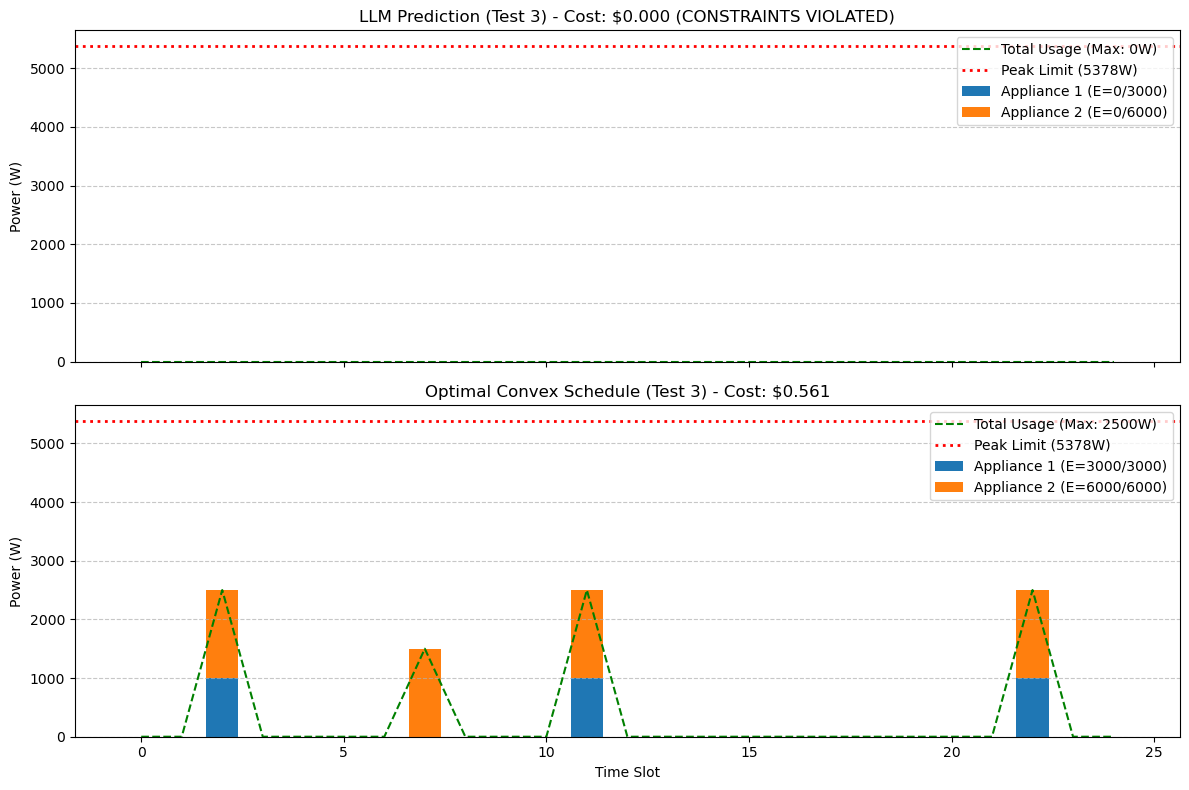


--- Test Summary ---
+--------+---------------+--------------+-----------+------------------+-----------------------------+-------------+
|   Test |   Cost (Pred) |   Cost (Opt) |   Gap ($) |   Optimality (%) | Pred Valid                  | Opt Valid   |
+========+===============+==============+===========+==================+=============================+=============+
|      1 |         0.239 |        0.696 |    -0.457 |           34.397 | No (E:[False False] P:True) | Yes         |
+--------+---------------+--------------+-----------+------------------+-----------------------------+-------------+
|      2 |         0     |        0.547 |    -0.547 |            0     | No (E:[False False] P:True) | Yes         |
+--------+---------------+--------------+-----------+------------------+-----------------------------+-------------+
|      3 |         0     |        0.561 |    -0.561 |            0     | No (E:[False False] P:True) | Yes         |
+--------+---------------+--------------+-

In [2]:
# Install everything
!pip install transformers bitsandbytes peft torch cvxpy numpy matplotlib tabulate accelerate huggingface_hub

# Imports
import torch
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, TaskType
import re
from tabulate import tabulate
import time
import os # Added for saving model/tokenizer
from huggingface_hub import login # For gated models

torch.cuda.empty_cache()

# --- Hugging Face Login (if using gated models like official Llama 2/3) ---
# You should have already run `huggingface-cli login` in your terminal
# or you can attempt to login programmatically (less recommended for unattended scripts)
# try:
# print("Attempting Hugging Face login...")
# login() # Will prompt for token if not already configured
# print("Login successful or already logged in.")
# except Exception as e:
# print(f"Hugging Face login failed or not configured. You may not be able to download gated models. Error: {e}")
# print("Please ensure you have run 'huggingface-cli login' and accepted model terms if needed.")


# 1) Convex Oracle (No changes needed)
def generate_optimal_schedule(price, P_h, E_h, peak_limit):
    N, H = len(price), len(P_h)
    X = cp.Variable((N, H))
    power = cp.multiply(X, P_h.reshape(1, H))
    cost = cp.sum(cp.multiply(price.reshape(N, 1), power)) / 1000.0
    constraints = [
        cp.sum(power, axis=0) >= E_h,
        cp.sum(power, axis=1) <= peak_limit,
        X >= 0, X <= 1
    ]
    prob = cp.Problem(cp.Minimize(cost), constraints)
    # Using a robust solver like SCS can sometimes help if default fails
    try:
        prob.solve(verbose=False, solver=cp.SCS)
        if X.value is None: # Fallback if SCS fails or returns None
            print("Warning: SCS solver failed or returned None, trying default solver ECOS.")
            prob.solve(verbose=False, solver=cp.ECOS)
    except cp.SolverError:
        print("Warning: Default solver failed, trying ECOS.")
        try:
            prob.solve(verbose=False, solver=cp.ECOS)
        except cp.SolverError:
            print("Warning: ECOS solver also failed, trying SCS again.")
            prob.solve(verbose=False, solver=cp.SCS) # Last attempt with SCS

    if X.value is None:
        print("Error: Optimization failed to find a solution after trying multiple solvers. Returning zeros.")
        return np.zeros((N,H), dtype=float) # Return feasible zeros if solver fails

    return X.value.astype(float)

# 2) Dataset (No changes needed)
class TSLSupervisedDatasetStructured(Dataset):
    def __init__(self, n_samples, N, H):
        self.prompts = []
        self.targets = []
        self.N, self.H = N, H
        # Consistent appliance definitions across dataset
        self.P_h = np.array([1000, 1500]) # Watts
        self.E_h = np.array([3000, 6000]) # Watt-hours
        self.peak_range = (2000, 6000) # Watts

        generated_count = 0
        attempts = 0
        max_attempts = n_samples * 3 # Allow for more failures, esp. with stricter feasibility

        print(f"Attempting to generate {n_samples} valid dataset samples...")
        while generated_count < n_samples and attempts < max_attempts:
            attempts += 1
            price = 0.05 + (0.2 - 0.05) * np.random.rand(N) # $/kWh
            peak_limit = np.random.randint(*self.peak_range) # Watts

            if np.sum(self.E_h) > N * peak_limit : # Basic check: total energy demand vs max possible energy supply
                 # print(f"Skipping potentially infeasible scenario (Peak: {peak_limit}, Sum Energy: {np.sum(self.E_h)}, Max possible: {N*peak_limit})")
                 continue

            # Stricter pre-check: ensure each appliance *could* run enough, even if not optimal
            min_hours_needed = self.E_h / self.P_h
            if np.any(min_hours_needed > N): # If any appliance needs more slots than available
                # print(f"Skipping: Appliance needs more slots than available. Min hours: {min_hours_needed}")
                continue
            if np.sum(self.E_h / N) > peak_limit : # Average power needed per slot > peak limit
                # print(f"Skipping: Average power needed ({np.sum(self.E_h / N)}) exceeds peak limit ({peak_limit})")
                continue


            X_opt = generate_optimal_schedule(price, self.P_h, self.E_h, peak_limit)

            if X_opt is not None and not np.isnan(X_opt).any() and X_opt.shape == (N, H): # Check shape too
                power_opt = X_opt * self.P_h.reshape(1, H)
                energy_met = np.all(np.sum(power_opt, axis=0) >= (self.E_h - 1e-2)) # Increased tolerance
                peak_ok = np.all(np.sum(power_opt, axis=1) <= (peak_limit + 1e-2)) # Increased tolerance

                if energy_met and peak_ok:
                    self.prompts.append(self._build_prompt(price, peak_limit))
                    self.targets.append(torch.tensor(X_opt.flatten(), dtype=torch.float32))
                    generated_count += 1
                # else:
                    # print(f"Skipping sample - constraints not met after solve. Energy met: {energy_met}, Peak ok: {peak_ok}. Energy: {np.sum(power_opt, axis=0)}, Peak: {np.max(np.sum(power_opt, axis=1))}")
            # else:
                # print(f"Skipping sample - solver failed or returned unexpected result (None or NaN or wrong shape).")

            if attempts % (max_attempts // 10 if max_attempts >=10 else 1) == 0 : # Print progress more often
                 print(f"Attempt {attempts}/{max_attempts}, Generated {generated_count}/{n_samples}")


        if generated_count < n_samples:
            print(f"Warning: Could only generate {generated_count}/{n_samples} valid samples.")
        else:
            print(f"Successfully generated {generated_count} dataset samples.")


    def _build_prompt(self, price, peak_limit):
        s = "<Instruction>\n"
        s += "Given the electricity prices per slot, appliance specifications, and a peak power limit, determine the optimal activation schedule (proportion of time each appliance runs in each slot) to minimize total electricity cost, while ensuring each appliance meets its total energy requirement and the peak power limit is never exceeded.\n\n"
        s += "[Prices]\n" + "\n".join(f"Slot {i+1}: {p:.3f} $/kWh" for i, p in enumerate(price))
        s += "\n\n[Appliances]\n"
        for i, (pw, eg) in enumerate(zip(self.P_h, self.E_h), start=1):
            s += f"Appliance {i}:\n  Rated Power: {pw/1000:.1f} kW\n  Energy Required: {eg/1000:.1f} kWh\n"
        s += f"\n[Peak Limit]\n{peak_limit/1000:.1f} kW\n"
        s += "\n[Objective]\nMinimize total electricity cost.\n"
        s += f"\n[Output Format]\nPlease provide only the activation schedule as a {self.N}x{self.H} matrix.\n"
        s += f"Format it as {self.N} rows, each row containing {self.H} numbers (between 0.0 and 1.0, representing activation proportion) separated by a comma.\n"
        s += "Separate the rows with a semicolon.\n"
        s += "Example row for H=2: 0.5,1.0;\n" # Clarified example for H=2
        s += "The output must end with a semicolon after the last row.\n"
        s += "Do not include any other text, explanations, or labels in the output.\n"
        s += "</Instruction>\n<Response>\n"
        return s

    def __len__(self):
        return len(self.prompts)

    def __getitem__(self, idx):
        return self.prompts[idx], self.targets[idx]

# 3) LLM Scheduler Class (Modified from TinyLlamaScheduler)
class LLMScheduler:
    def __init__(self, model_name="NousResearch/Llama-2-7b-chat-hf"): # CHANGED model name
        # model_name="meta-llama/Llama-2-7b-chat-hf" # Example for official Llama 2 (requires access)
        # model_name="meta-llama/Meta-Llama-3-8B-Instruct" # Example for Llama 3 (requires access)
        self.model_name = model_name
        print(f"Initializing LLMScheduler with model: {self.model_name}")
        self.tokenizer = AutoTokenizer.from_pretrained(
            self.model_name,
            # trust_remote_code=True # Uncomment if needed for specific model
        )

        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token
            print("Set pad_token to eos_token")
            if self.tokenizer.pad_token is None: # If eos_token is also None
                 self.tokenizer.add_special_tokens({'pad_token': '[PAD]'})
                 print("eos_token was None. Added new [PAD] token.")


        # Quantization configuration
        bnb_config = BitsAndBytesConfig(
            load_in_8bit=True, # Use 8-bit quantization
            # load_in_4bit=True, # Alternative: 4-bit for even less memory, but may impact performance
            # bnb_4bit_use_double_quant=True, # For 4-bit
            # bnb_4bit_quant_type="nf4", # For 4-bit
            # bnb_4bit_compute_dtype=torch.bfloat16 # For 4-bit
        )

        # Load the model
        print(f"Loading model {self.model_name} with quantization...")
        model = AutoModelForCausalLM.from_pretrained(
            self.model_name,
            device_map="auto",
            quantization_config=bnb_config,
            # trust_remote_code=True # Uncomment if model requires custom code execution
        )
        print("Model loaded.")

        # Prepare model for k-bit training
        model = prepare_model_for_kbit_training(model)
        print("Model prepared for k-bit training.")

        # LoRA configuration
        lora_config = LoraConfig(
            r=16,
            lora_alpha=32,
            target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"], # Common for Llama
            lora_dropout=0.05,
            bias="none",
            task_type=TaskType.CAUSAL_LM,
        )

        # Apply LoRA adapter
        model = get_peft_model(model, lora_config)
        model.print_trainable_parameters()

        self.model = model
        self.model.eval()
        self.N = None
        self.H = None

    def fine_tune(self, dataset, epochs=1, batch_size=1, lr=2e-4):
        self.model.train()
        self.N = dataset.N
        self.H = dataset.H
        if self.N is None or self.H is None:
            raise ValueError("Dataset N and H must be set before fine-tuning")

        loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        optimizer = AdamW(self.model.parameters(), lr=lr)
        loss_history = []

        print(f"Starting fine-tuning with N={self.N}, H={self.H}, BS={batch_size}, LR={lr} for {epochs} epochs.")

        for ep in range(1, epochs + 1):
            running_loss = 0.0
            processed_batches = 0
            for i, (prompts, targets) in enumerate(loader):
                full_texts = []
                for prompt, target_flat in zip(prompts, targets):
                    target_matrix = target_flat.reshape(self.N, self.H)
                    schedule_text = ";".join(",".join(f"{v:.1f}" for v in target_matrix[j]) for j in range(self.N)) + ";"

                    if prompt.strip().endswith("<Response>"):
                        full_text = prompt.strip() + "\n" + schedule_text + self.tokenizer.eos_token
                    else:
                        full_text = prompt + "\n<Response>\n" + schedule_text + self.tokenizer.eos_token
                    full_texts.append(full_text)

                encodings = self.tokenizer(full_texts, return_tensors="pt", padding=True, truncation=True, max_length=1024).to(self.model.device)
                labels = encodings["input_ids"].clone()
                labels[labels == self.tokenizer.pad_token_id] = -100

                # --- Prompt Masking (Optional but can be very helpful) ---
                # Create attention mask for labels to only compute loss on the response part.
                # This requires finding the start of the response for each item in the batch.
                # For simplicity here, we'll compute loss on the whole sequence (including prompt).
                # For more advanced training, you would do something like this:
                # response_starts = []
                # for k_idx, prompt_text_only in enumerate(prompts):
                #     # Tokenize prompt only to find its length
                #     prompt_tokens = self.tokenizer(prompt_text_only, return_tensors="pt", add_special_tokens=False).input_ids.shape[1]
                #     response_starts.append(prompt_tokens) # Approximate start
                #
                # for k_idx in range(labels.shape[0]):
                #     # Find the actual token position where response begins.
                #     # This needs to be robust. Using length of prompt tokenization.
                #     # Careful: tokenization of prompt_text_only vs. part of full_texts[k_idx] can differ slightly.
                #     # A more robust way is to tokenize "<Response>\n" and find its position.
                #     labels[k_idx, :response_starts[k_idx]] = -100 # Mask out prompt tokens
                # --- End Prompt Masking Example ---


                outputs = self.model(**encodings, labels=labels)
                loss = outputs.loss

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                processed_batches += 1
                if i % (len(loader)//5 if len(loader) >=5 else 1) == 0: # Print progress within epoch
                    print(f"  Epoch {ep}, Batch {i+1}/{len(loader)}, Current Batch Loss: {loss.item():.6f}")


            avg_loss = running_loss / processed_batches if processed_batches > 0 else 0.0
            loss_history.append(avg_loss)
            print(f"Fine-tuning Epoch {ep}/{epochs} — Avg Loss: {avg_loss:.6f}")

        self.model.eval()

        plt.figure(figsize=(8, 4))
        plt.plot(range(1, epochs + 1), loss_history, marker='o')
        plt.title(f'Fine-tuning Loss Curve ({self.model_name.split("/")[-1]})')
        plt.xlabel('Epoch')
        plt.ylabel('Average Loss')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        return self

    def generate_schedule(self, prompt):
        self.model.eval()
        if not prompt.strip().endswith("<Response>"):
            prompt = prompt.strip() + "\n<Response>\n"

        inputs = self.tokenizer(prompt, return_tensors="pt", padding=True, truncation=True, max_length=1024).to(self.model.device) # Increased max_length for prompt

        # Estimate tokens needed for N x H matrix output string
        # N rows * (H numbers * (avg 3 chars for "0.X" + 1 comma) + 1 semicolon)
        # Example: N=25, H=2 -> 25 * (2 * (3+1) + 1) = 25 * 9 = 225 tokens
        # Add buffer
        estimated_tokens = self.N * (self.H * 4 + self.H) + 60 # Increased buffer slightly
        max_new_tokens = min(estimated_tokens, 500) # Cap max new tokens (e.g., to 500, was 400)
        # print(f"Generating schedule, N={self.N}, H={self.H}, estimated_tokens={estimated_tokens}, max_new_tokens={max_new_tokens}")


        with torch.no_grad():
            outputs = self.model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                do_sample=False, # Greedy decoding
                pad_token_id=self.tokenizer.eos_token_id if self.tokenizer.eos_token_id is not None else self.model.config.eos_token_id,
                eos_token_id=self.tokenizer.eos_token_id if self.tokenizer.eos_token_id is not None else self.model.config.eos_token_id,
                num_beams=1 # Use 1 for greedy
            )

        generated_ids = outputs[0, inputs['input_ids'].shape[1]:]
        generated_text = self.tokenizer.decode(generated_ids, skip_special_tokens=True)
        return generated_text.strip()

# 4) Parse output (More robust parsing attempts)
def parse_llm_output(output_str, N, H):
    # print(f"Attempting to parse LLM output (first 300 chars): '{output_str[:300]}'")
    # Expected format: "0.1,0.2;0.3,0.4;..." for N rows, H columns
    # Try to extract the schedule part first, tolerant to leading/trailing non-schedule text.
    # This regex looks for N lines each containing H float numbers separated by commas, ending with a semicolon.
    # It's more flexible with spacing around numbers and separators.
    # A single number is like: \s* \d\.\d+ \s*
    # A row is: (number, number, ..., number);
    # So for H=2: (\s*\d\.\d+\s*,\s*\d\.\d+\s*;)

    # Dynamically build regex for H columns
    num_pattern = r"\s*(\d\.\d+)\s*" # Captures one number like "0.1" or " 1.0 "
    row_parts = [num_pattern] * H
    row_pattern_str = r"(" + r",".join(row_parts) + r"\s*;" + r")"
    # print(f"Using row pattern: {row_pattern_str}")

    schedule = np.zeros((N, H))
    parsed_rows_count = 0

    # First, try to find the block of schedules using a broader match
    # This helps if the LLM adds "Here is the schedule:" or similar before the actual data.
    block_match = re.search(r"((?:" + num_pattern + r",)*(?:" + num_pattern + r");)+", output_str, re.MULTILINE)
    if block_match:
        # print("Found a potential schedule block.")
        data_block = block_match.group(0)
    else:
        # print("No clear schedule block found, parsing entire output.")
        data_block = output_str # Fallback to the whole output

    # Split the data_block into potential rows based on the semicolon
    potential_rows_str = data_block.strip().split(';')
    # Filter out empty strings that might result from trailing semicolons
    potential_rows_str = [row.strip() for row in potential_rows_str if row.strip()]

    # print(f"Found {len(potential_rows_str)} potential rows after splitting by ';'.")

    for i in range(N): # Iterate up to N expected rows
        if i < len(potential_rows_str):
            row_str = potential_rows_str[i]
            # print(f"Processing potential row {i+1}: '{row_str}'")
            try:
                # Split by comma and convert to float
                values_str = row_str.split(',')
                values = [float(v.strip()) for v in values_str]

                if len(values) == H:
                    schedule[i, :] = values
                    parsed_rows_count += 1
                # elif len(values) > H and parsed_rows_count < N : # If LLM outputs too many columns for a row
                #     print(f"Parsing warning: Row {i+1} has too many values ({len(values)}/{H}). Taking first {H}. String: '{row_str}'")
                #     schedule[i, :] = values[:H]
                #     parsed_rows_count +=1
                else:
                    print(f"Parsing warning: Row {i+1} has incorrect number of values ({len(values)}/{H}). String: '{row_str}'")
                    # Fallback: If previous row was good, try to use its sum characteristic if this one is just one number
                    if i > 0 and len(values) == 1 and H > 1:
                         print(f"  Trying fallback for row {i+1} based on previous row sum characteristic if only one number.")
                         # This is a very heuristic fallback, use with caution or remove
                         # if np.sum(schedule[i-1,:]) > 0.1 and np.sum(schedule[i-1,:]) < H - 0.1: # if prev not all 0s or all 1s
                         #    schedule[i,0] = values[0]
                         #    schedule[i,1:] = (np.sum(schedule[i-1,:]) - values[0]) / (H-1) # distribute remaining
                         #    parsed_rows_count +=1


            except ValueError as e:
                print(f"Parsing error in row {i+1}: Could not convert values. String: '{row_str}'. Error: {e}")
            except Exception as e_gen: # Catch any other parsing error for this row
                print(f"Generic parsing error for row {i+1}: '{row_str}'. Error: {e_gen}")
        else:
            if parsed_rows_count < N : # Only print if we expected more rows
                 print(f"Parsing warning: Expected {N} rows, but found only {len(potential_rows_str)} processable row strings.")
            break # Stop if we run out of potential rows

    # print(f"Parsed {parsed_rows_count}/{N} rows successfully through primary method.")

    # If not all rows were parsed, try a more direct regex match on the original output_str as a fallback
    if parsed_rows_count < N:
        # print("Attempting fallback regex matching on the full output due to incomplete parse.")
        try:
            # This regex finds individual rows matching the N x H structure more directly
            # It looks for: (optional spaces) digit.digits (optional spaces) , (optional spaces) digit.digits (optional spaces) ;
            # It's less forgiving than split-based but can find isolated valid rows.
            # Dynamically build regex for H columns
            num_pattern_rgx = r"\s*\d\.\d+\s*"
            row_content_pattern_rgx = r",".join([num_pattern_rgx] * H) # e.g., \s*\d\.\d+\s*,\s*\d\.\d+\s*
            full_row_pattern_rgx = r"(" + row_content_pattern_rgx + r"\s*;" + r")" # Enclose in () to capture the whole row string "0.1,0.2;"

            matches = re.findall(full_row_pattern_rgx, output_str) # Find all such row strings

            # print(f"Fallback regex found {len(matches)} potential row strings.")
            # if matches: print(f"  First match: {matches[0][:50]}")


            temp_schedule_fallback = np.zeros((N, H))
            parsed_rows_fallback = 0
            for i, row_group_match in enumerate(matches):
                if i >= N: break # Don't parse more than N rows
                row_str_match = row_group_match # The first element of the tuple if findall captures groups

                # Clean the matched row string: remove semicolon and extra spaces
                cleaned_row_str = row_str_match.strip().rstrip(';')
                # print(f"  Fallback processing matched row {i+1}: '{cleaned_row_str}'")
                try:
                    values = [float(v.strip()) for v in cleaned_row_str.split(',')]
                    if len(values) == H:
                        temp_schedule_fallback[i, :] = values
                        parsed_rows_fallback += 1
                    else:
                        print(f"  Fallback warning: Row {i+1} (from regex match) has {len(values)}/{H} values. String: '{row_str_match}'")
                except ValueError:
                    print(f"  Fallback error: Could not convert values in regex matched row {i+1}. String: '{row_str_match}'")

            if parsed_rows_fallback > parsed_rows_count:
                print(f"Fallback regex parsing yielded more rows ({parsed_rows_fallback}). Using this result.")
                schedule = temp_schedule_fallback
                parsed_rows_count = parsed_rows_fallback
            # else:
                # print(f"Fallback regex parsing did not improve row count ({parsed_rows_fallback} vs {parsed_rows_count}). Sticking with primary parse result.")


        except Exception as e_re:
            print(f"Critical error during fallback regex parsing: {e_re}")


    if parsed_rows_count < N:
        print(f"Parsing Warning: Final parsed rows {parsed_rows_count} is less than expected {N}. The schedule matrix might be incomplete (padded with zeros).")
    elif parsed_rows_count > N:
        print(f"Parsing Warning: Parsed {parsed_rows_count} rows, more than expected {N}. Truncating to {N} rows.")
        schedule = schedule[:N, :]


    return np.clip(schedule, 0, 1)


# 5) Test and Plot Function (No fundamental changes, but uses the LLMScheduler instance)
def test_and_plot(scheduler_instance, tests=5, N=25, H=2):
    import matplotlib.pyplot as plt
    import numpy as np

    P_h = np.array([1000, 1500])
    E_h = np.array([3000, 6000])
    peak_range = (2000, 6000)

    model = scheduler_instance.model
    model.eval()

    results = []
    print(f"\n--- Running {tests} Test Scenarios ---")

    for t_i in range(1, tests + 1):
        print(f"\n--- Test Scenario {t_i}/{tests} ---")
        price = 0.05 + (0.2 - 0.05) * np.random.rand(N)
        peak = np.random.randint(*peak_range)

        # Replicating builder logic for consistency (same as in dataset)
        def _build_test_prompt(price_arr, peak_val, P_h_arr, E_h_arr, N_slots, H_app):
            s = "<Instruction>\n"
            s += "Given the electricity prices per slot, appliance specifications, and a peak power limit, determine the optimal activation schedule (proportion of time each appliance runs in each slot) to minimize total electricity cost, while ensuring each appliance meets its total energy requirement and the peak power limit is never exceeded.\n\n"
            s += "[Prices]\n" + "\n".join(f"Slot {j+1}: {p:.3f} $/kWh" for j, p in enumerate(price_arr))
            s += "\n\n[Appliances]\n"
            for j, (pw, eg) in enumerate(zip(P_h_arr, E_h_arr), start=1):
                s += f"Appliance {j}:\n  Rated Power: {pw/1000:.1f} kW\n  Energy Required: {eg/1000:.1f} kWh\n"
            s += f"\n[Peak Limit]\n{peak_val/1000:.1f} kW\n"
            s += "\n[Objective]\nMinimize total electricity cost.\n"
            s += f"\n[Output Format]\nPlease provide only the activation schedule as a {N_slots}x{H_app} matrix.\n"
            s += f"Format it as {N_slots} rows, each row containing {H_app} numbers (between 0.0 and 1.0, representing activation proportion) separated by a comma.\n"
            s += "Separate the rows with a semicolon.\n"
            s += f"Example row for H={H_app}: 0.5,1.0;\n" # Adjusted for H_app
            s += "The output must end with a semicolon after the last row.\n"
            s += "Do not include any other text, explanations, or labels in the output.\n"
            s += "</Instruction>\n<Response>\n"
            return s

        prompt_text = _build_test_prompt(price, peak, P_h, E_h, N, H)
        # print(f"Test Prompt (first 200 chars):\n{prompt_text[:200]}")

        generated_output = scheduler_instance.generate_schedule(prompt_text)
        print(f"Generated Output (Raw - first 300 chars):\n---\n{generated_output[:300]}\n---")

        pred_sched = parse_llm_output(generated_output, N, H)
        print(f"Parsed Schedule (Predicted):\n{tabulate(pred_sched, floatfmt='.2f')}")

        opt_sched = generate_optimal_schedule(price, P_h, E_h, peak)
        if opt_sched is None or np.isnan(opt_sched).any() or opt_sched.shape != (N,H):
            print("Warning: Optimal solver failed or returned invalid shape for this test case. Skipping comparison plots/metrics.")
            results.append({
                "Test": t_i, "Cost (Pred)": float('nan'), "Cost (Opt)": float('nan'),
                "Gap ($)": float('nan'), "Optimality (%)": float('nan'),
                "Pred Valid": "N/A", "Opt Valid": "Failed",
            })
            continue

        print(f"Optimal Schedule:\n{tabulate(opt_sched, floatfmt='.2f')}")

        pred_power = pred_sched * P_h.reshape(1, H)
        pred_energy_total = np.sum(pred_power, axis=0)
        pred_peak_usage = np.sum(pred_power, axis=1)
        # More tolerant validation for LLM output: allow 5% deviation for energy, slightly higher for peak
        pred_energy_met = pred_energy_total >= (E_h * 0.95) # 95% of energy
        pred_peak_ok = np.all(pred_peak_usage <= (peak + 50)) # Allow 50W over peak
        pred_valid = np.all(pred_energy_met) and pred_peak_ok

        opt_power = opt_sched * P_h.reshape(1, H)
        opt_energy_total = np.sum(opt_power, axis=0)
        opt_peak_usage = np.sum(opt_power, axis=1)
        opt_energy_met = opt_energy_total >= (E_h - 1) # Stricter for optimal
        opt_peak_ok = np.all(opt_peak_usage <= (peak + 1))
        opt_valid = np.all(opt_energy_met) and opt_peak_ok

        cost_pred = np.sum(price.reshape(N, 1) * pred_power) / 1000.0
        cost_opt = np.sum(price.reshape(N, 1) * opt_power) / 1000.0 if opt_valid else float('inf')

        gap = cost_pred - cost_opt if opt_valid else float('nan')
        optimality_ratio = (cost_pred / cost_opt) * 100 if cost_opt > 1e-6 and opt_valid else float('inf')

        results.append({
            "Test": t_i,
            "Cost (Pred)": cost_pred, "Cost (Opt)": cost_opt,
            "Gap ($)": gap, "Optimality (%)": optimality_ratio,
            "Pred Valid": "Yes" if pred_valid else f"No (E:{pred_energy_met} P:{pred_peak_ok})",
            "Opt Valid": "Yes" if opt_valid else "No",
        })
        print(f"Prediction valid: {pred_valid}, Optimal valid: {opt_valid}")
        print(f"Energy Pred: {pred_energy_total.round(1)} (Req: {E_h})")
        print(f"Max Peak Pred: {np.max(pred_peak_usage).round(1)} (Limit: {peak})")
        print(f"Energy Opt: {opt_energy_total.round(1)} (Req: {E_h})")
        print(f"Max Peak Opt: {np.max(opt_peak_usage).round(1)} (Limit: {peak})")
        print("-" * 20)

        t_range = np.arange(N)
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

        ax1.bar(t_range, pred_power[:,0], label=f"Appliance 1 (E={pred_energy_total[0]:.0f}/{E_h[0]})")
        ax1.bar(t_range, pred_power[:,1], bottom=pred_power[:,0], label=f"Appliance 2 (E={pred_energy_total[1]:.0f}/{E_h[1]})")
        ax1.plot(t_range, pred_peak_usage, 'g--', label=f'Total Usage (Max: {np.max(pred_peak_usage):.0f}W)')
        ax1.axhline(peak, color='r', linestyle=':', linewidth=2, label=f"Peak Limit ({peak}W)")
        title_pred = f"LLM Prediction (Test {t_i}) - Cost: ${cost_pred:.3f}"
        if not pred_valid: title_pred += " (CONSTRAINTS VIOLATED)"
        ax1.set_title(title_pred)
        ax1.set_ylabel("Power (W)")
        ax1.legend(loc='upper right')
        ax1.grid(True, axis='y', linestyle='--', alpha=0.7)
        ax1.set_ylim(bottom=0)

        ax2.bar(t_range, opt_power[:,0], label=f"Appliance 1 (E={opt_energy_total[0]:.0f}/{E_h[0]})")
        ax2.bar(t_range, opt_power[:,1], bottom=opt_power[:,0], label=f"Appliance 2 (E={opt_energy_total[1]:.0f}/{E_h[1]})")
        ax2.plot(t_range, opt_peak_usage, 'g--', label=f'Total Usage (Max: {np.max(opt_peak_usage):.0f}W)')
        ax2.axhline(peak, color='r', linestyle=':', linewidth=2, label=f"Peak Limit ({peak}W)")
        ax2.set_title(f"Optimal Convex Schedule (Test {t_i}) - Cost: ${cost_opt:.3f}")
        ax2.set_xlabel("Time Slot")
        ax2.set_ylabel("Power (W)")
        ax2.legend(loc='upper right')
        ax2.grid(True, axis='y', linestyle='--', alpha=0.7)
        ax2.set_ylim(bottom=0)

        plt.tight_layout()
        plt.show()

    print("\n--- Test Summary ---")
    if results:
        headers = results[0].keys()
        rows = [list(r.values()) for r in results]
        formatted_rows = []
        for row in rows:
            new_row = []
            for item in row:
                if isinstance(item, float):
                    new_row.append(f"{item:.3f}" if abs(item) < 1000 else f"{item:.2f}")
                else:
                    new_row.append(item)
            formatted_rows.append(new_row)
        print(tabulate(formatted_rows, headers=headers, tablefmt="grid"))

        valid_gaps = [r["Gap ($)"] for r in results if isinstance(r["Gap ($)"], float) and not np.isnan(r["Gap ($)"]) and "Yes" in str(r["Pred Valid"]) and "Yes" in str(r["Opt Valid"])]
        valid_ratios = [r["Optimality (%)"] for r in results if isinstance(r["Optimality (%)"], float) and not np.isinf(r["Optimality (%)"]) and "Yes" in str(r["Pred Valid"]) and "Yes" in str(r["Opt Valid"])]
        num_pred_valid_strict = sum(1 for r in results if "Yes" == str(r["Pred Valid"])) # Stricter check

        avg_gap = np.mean(valid_gaps) if valid_gaps else float('nan')
        avg_ratio = np.mean(valid_ratios) if valid_ratios else float('nan')
        print(f"\nAverage Gap (Valid Preds & Opts): ${avg_gap:.3f}")
        print(f"Average Optimality Ratio (Valid Preds & Opts): {avg_ratio:.2f}%")
        print(f"Strictly Valid Predictions: {num_pred_valid_strict}/{tests}")
    else:
        print("No results to summarize.")


# 6) Main Execution Block
if __name__ == "__main__":
    start_time = time.perf_counter()

    # --- Configuration ---
    N, H = 25, 2
    DATASET_SIZE = 100 # Reduced for Llama model due to longer processing time
    EPOCHS = 5         # As per user request
    BATCH_SIZE = 1     # Reduced due to larger model size (adjust based on GPU VRAM)
    LEARNING_RATE = 5e-5 # Adjusted LR, often smaller LR for larger models
    NUM_TESTS = 3      # Reduced for quicker run-through with a larger model
    
    # --- CHOOSE YOUR LLAMA MODEL HERE ---
    # Option 1: NousResearch Llama-2 (usually no special access needed beyond HF login)
    CHOSEN_MODEL_NAME = "NousResearch/Llama-2-7b-chat-hf"
    # Option 2: Official Meta Llama-2 (REQUIRES ACCESS ON HUGGING FACE HUB)
    # CHOSEN_MODEL_NAME = "meta-llama/Llama-2-7b-chat-hf"
    # Option 3: Official Meta Llama-3 (REQUIRES ACCESS ON HUGGING FACE HUB)
    # CHOSEN_MODEL_NAME = "meta-llama/Meta-Llama-3-8B-Instruct"
    # Ensure you have logged in via `huggingface-cli login` if using gated models.

    # Sanitize model name for file paths
    safe_model_name = CHOSEN_MODEL_NAME.replace("/", "_")
    MODEL_SAVE_PATH = f"./{safe_model_name}-scheduler-model"
    TOKENIZER_SAVE_PATH = f"./{safe_model_name}-scheduler-tokenizer"


    print(f"Using model: {CHOSEN_MODEL_NAME}")
    print(f"Dataset Size: {DATASET_SIZE}, Epochs: {EPOCHS}, Batch Size: {BATCH_SIZE}, LR: {LEARNING_RATE}")


    # --- Dataset Generation ---
    print(f"\n--- Generating Dataset ({DATASET_SIZE} samples) ---")
    ds_start_time = time.perf_counter()
    ds = TSLSupervisedDatasetStructured(DATASET_SIZE, N, H)
    ds_end_time = time.perf_counter()
    if len(ds) == 0:
        print("FATAL: Dataset generation failed. Exiting.")
        exit()
    elif len(ds) < DATASET_SIZE:
        print(f"Warning: Generated only {len(ds)} samples out of requested {DATASET_SIZE}.")
    print(f"Dataset generated in {ds_end_time - ds_start_time:.2f} seconds.")

    # --- Model Loading ---
    print(f"\n--- Loading LLM ({CHOSEN_MODEL_NAME}) with LoRA ---")
    load_start_time = time.perf_counter()
    scheduler = LLMScheduler(model_name=CHOSEN_MODEL_NAME)
    scheduler.N, scheduler.H = ds.N, ds.H
    load_end_time = time.perf_counter()
    print(f"Model loaded in {load_end_time - load_start_time:.2f} seconds.")

    # --- Fine-tuning ---
    print(f"\n--- Fine-tuning (LoRA) for {EPOCHS} Epochs ---")
    tune_start_time = time.perf_counter()
    scheduler.fine_tune(ds, epochs=EPOCHS, batch_size=BATCH_SIZE, lr=LEARNING_RATE)
    tune_end_time = time.perf_counter()
    print(f"Fine-tuning completed in {tune_end_time - tune_start_time:.2f} seconds.")

    # --- Testing ---
    print(f"\n--- Testing Model on {NUM_TESTS} Scenarios ---")
    test_start_time = time.perf_counter()
    test_and_plot(scheduler, tests=NUM_TESTS, N=N, H=H)
    test_end_time = time.perf_counter()
    print(f"Testing completed in {test_end_time - test_start_time:.2f} seconds.")

    # --- Saving Model and Tokenizer ---
    print("\n--- Saving Fine-tuned Model and Tokenizer ---")
    save_start_time = time.perf_counter()
    try:
        os.makedirs(MODEL_SAVE_PATH, exist_ok=True)
        os.makedirs(TOKENIZER_SAVE_PATH, exist_ok=True)
        scheduler.model.save_pretrained(MODEL_SAVE_PATH)
        print(f"PEFT Model saved to: {MODEL_SAVE_PATH}")
        scheduler.tokenizer.save_pretrained(TOKENIZER_SAVE_PATH)
        print(f"Tokenizer saved to: {TOKENIZER_SAVE_PATH}")
    except Exception as e:
        print(f"Error saving model/tokenizer: {e}")
    save_end_time = time.perf_counter()
    print(f"Saving completed in {save_end_time - save_start_time:.2f} seconds.")

    end_time = time.perf_counter()
    total_elapsed_time = end_time - start_time
    minutes = int(total_elapsed_time // 60)
    seconds = total_elapsed_time % 60
    print("\n" + "="*40)
    print(f"Total script execution time: {total_elapsed_time:.2f} seconds")
    if minutes > 0:
        print(f"Which is approximately {minutes} minute(s) and {seconds:.2f} second(s).")
    print("="*40)